In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import numpy as np
from torch.utils.data import DataLoader

from custom_module_trainer import CustomModuleTrainer
# from torchsample.modules import ModuleTrainer
from torchsample.callbacks import EarlyStopping

from model_trainer import ModelTrainer

from models.model_scalar import MixingModelScalar
from models.model_scalar_v2 import MixingModelScalar2d
from models.model_dummy import ModelDummy
from data.dataset import MultitrackAudioDataset
from data.medleydb_split import train_songlist, weathervane_music, musdb18_mixed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

print(torch.backends.cudnn.version())
torch.backends.cudnn.benchmark = True

Torch version:  1.6.0
Device:  cuda
7605


In [4]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
seed = 321
chunk_length = 1

In [5]:
d = MultitrackAudioDataset(
    base_path,
    songlist=musdb18_mixed,
    chunk_length=chunk_length,
    train_val_test_split=(1.0, 0.0, 0.0),
    mode='train',
    seed=seed,
    normalize=False
)

In [6]:
d._precompute_features()

[.] Pre-computing features...
------------------------------------------------------------
0/1: Bill Chudziak - Children Of No-one
0/230
30/230
60/230
90/230
120/230
150/230
180/230
210/230
[+] Features computed and saved


In [9]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='train',
    seed=seed,
    normalize=False
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='val',
    seed=seed,
    normalize=False
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))

Train: 20 tracks, 5419 chunks
Val: 5 tracks, 1230 chunks


-33.341057 46.658943 -9.890384
-1.0 1.0 -0.2617995


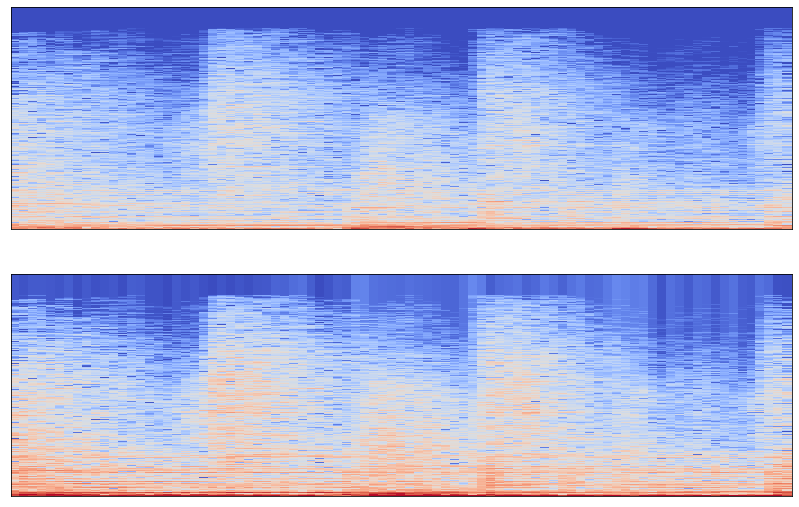

In [9]:
train_features, gt_features = d[50]

fig = plt.figure(figsize=(14, 9))

ax1 = plt.subplot(2,1,1)
print(np.min(gt_features), np.max(gt_features), np.mean(gt_features))
librosa.display.specshow(gt_features)

ax2 = plt.subplot(2,1,2, sharex=ax1)
norm_features = librosa.util.normalize(gt_features)
print(np.min(norm_features), np.max(norm_features), np.mean(norm_features))
librosa.display.specshow(norm_features)
plt.show()

In [6]:
train_loader = DataLoader(d_train,
                          batch_size=48,
                          shuffle=False,
                          num_workers=6,
                          pin_memory=True,
                          drop_last=False,
                          timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val,
                        batch_size=48,
                        shuffle=False,
                        num_workers=6,
                        pin_memory=True,
                        drop_last=False,
                        timeout=0,
                        worker_init_fn=None)

---
## Defining and training the model

In [10]:
# def train_model(model, criterion, optimizer, start_epoch, num_epochs, name='scalar'):
#     train_loss = []
#     val_loss = []

#     for epoch in range(start_epoch, start_epoch + num_epochs):
#         running_loss = 0.0

#         for i, batch in enumerate(train_loader):
# #             print(batch['train_features'].shape)
#             optimizer.zero_grad()
    
#             train_features, gt_features = batch
    
#             masked, masks = model(train_features.to(device))
#             loss = criterion(masked, gt_features.to(device))
#             loss.backward()
#             optimizer.step()

#             each_n_batches = 10
#             if i % each_n_batches == each_n_batches - 1:
#                 print('[%d, %4d] loss: %.3f' % (epoch, i + 1, loss.item()))

#             running_loss += loss.item()
            
#         avg_epoch_loss = running_loss / len(train_loader)
#         print('Epoch {} train loss: {:.4f}'.format(epoch, avg_epoch_loss))
#         train_loss.append(avg_epoch_loss)
        
#         # ---------------------------------------------------------------
#         # validation
#         running_val_loss = 0.0

#         with torch.no_grad():
#             for i, batch in enumerate(val_loader):
#                 train_features, gt_features = batch
#                 masked, masks = model(train_features.to(device))
#                 loss = criterion(masked, gt_features.to(device))
#                 running_val_loss += loss.item()

#         avg_epoch_val_loss = running_val_loss / len(val_loader)
#         print('Epoch {} val loss: {:.4f}'.format(epoch, avg_epoch_val_loss))
#         val_loss.append(avg_epoch_val_loss)
#         print('-' * 50)

#         if epoch % 2 == 0:
#             weights_file = os.path.join(weights_dir,
#                 'mixmodel_{}_1s_{:04d}_{:.4f}.pt'.format(name, epoch, avg_epoch_loss)) 
#             torch.save(model.state_dict(), weights_file)
    
#     return train_loss, val_loss

In [22]:
model = MixingModelScalar2d().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

908400 trainable parameters


In [24]:
# load weights if we want to continue training
weights = './weights/final/mixmodel_scalar2d_1s_0040_72.3425.pt'
# weights = './saved_models/scalar2d_scalar2d_1615.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [8]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [11]:
trainer = ModelTrainer(model, criterion, optimizer, device)

In [12]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 5)

Epoch 0/4
[10/ 113] loss: 245.342
[20/ 113] loss: 272.195
[30/ 113] loss: 125.189
[40/ 113] loss: 157.531
[50/ 113] loss: 150.977
[60/ 113] loss: 152.714
[70/ 113] loss: 97.269
[80/ 113] loss: 139.876
[90/ 113] loss: 301.298
[100/ 113] loss: 78.846
[110/ 113] loss: 80.431
Epoch 0 train loss: 175.6666
Epoch 0 val loss: 139.2077
--------------------------------------------------
Epoch 1/4
[10/ 113] loss: 216.343
[20/ 113] loss: 209.653
[30/ 113] loss: 119.855
[40/ 113] loss: 173.771
[50/ 113] loss: 146.948
[60/ 113] loss: 147.491
[70/ 113] loss: 108.413
[80/ 113] loss: 140.719
[90/ 113] loss: 286.478
[100/ 113] loss: 78.143
[110/ 113] loss: 79.429
Epoch 1 train loss: 161.7610
Epoch 1 val loss: 131.9366
--------------------------------------------------
Epoch 2/4
[10/ 113] loss: 201.708
[20/ 113] loss: 184.910
[30/ 113] loss: 105.048
[40/ 113] loss: 188.446
[50/ 113] loss: 164.968
[60/ 113] loss: 127.616
[70/ 113] loss: 123.989
[80/ 113] loss: 109.399
[90/ 113] loss: 242.800
[100/ 113] lo

In [9]:
start_epoch = 0
num_epochs = 20
train_loss, val_loss = train_model(model, criterion, optimizer, start_epoch, num_epochs, name='scalar_2d')

[0,   10] loss: 1681.469
[0,   20] loss: 1072.736
[0,   30] loss: 271.525
[0,   40] loss: 289.317
[0,   50] loss: 315.266
[0,   60] loss: 200.495
[0,   70] loss: 220.688
[0,   80] loss: 216.716
Epoch 0 train loss: 3482.7281
Epoch 0 val loss: 255.7367
--------------------------------------------------
[1,   10] loss: 634.628
[1,   20] loss: 249.146
[1,   30] loss: 95.500
[1,   40] loss: 276.270
[1,   50] loss: 213.075
[1,   60] loss: 164.234
[1,   70] loss: 173.236
[1,   80] loss: 201.453
Epoch 1 train loss: 270.1525
Epoch 1 val loss: 207.3432
--------------------------------------------------
[2,   10] loss: 443.679
[2,   20] loss: 231.673
[2,   30] loss: 90.696
[2,   40] loss: 255.355
[2,   50] loss: 174.179
[2,   60] loss: 140.110
[2,   70] loss: 153.935
[2,   80] loss: 187.597
Epoch 2 train loss: 232.9300
Epoch 2 val loss: 183.1668
--------------------------------------------------
[3,   10] loss: 361.049
[3,   20] loss: 205.201
[3,   30] loss: 87.080
[3,   40] loss: 227.049
[3,   5

In [11]:
start_epoch = 20
num_epochs = 10
train_loss2, val_loss2 = train_model(model, criterion, optimizer, start_epoch, num_epochs, name='scalar_2d')

[20,   10] loss: 214.371
[20,   20] loss: 110.958
[20,   30] loss: 47.839
[20,   40] loss: 80.929
[20,   50] loss: 96.338
[20,   60] loss: 88.035
[20,   70] loss: 68.040
[20,   80] loss: 88.377
Epoch 20 train loss: 109.0628
Epoch 20 val loss: 85.0079
--------------------------------------------------
[21,   10] loss: 219.342
[21,   20] loss: 111.221
[21,   30] loss: 49.991
[21,   40] loss: 90.079
[21,   50] loss: 108.606
[21,   60] loss: 90.005
[21,   70] loss: 67.718
[21,   80] loss: 85.420
Epoch 21 train loss: 107.5181
Epoch 21 val loss: 78.8233
--------------------------------------------------
[22,   10] loss: 211.081
[22,   20] loss: 111.375
[22,   30] loss: 47.020
[22,   40] loss: 79.029
[22,   50] loss: 97.665
[22,   60] loss: 86.651
[22,   70] loss: 68.250
[22,   80] loss: 86.964
Epoch 22 train loss: 105.1868
Epoch 22 val loss: 79.2096
--------------------------------------------------
[23,   10] loss: 210.417
[23,   20] loss: 111.139
[23,   30] loss: 47.780
[23,   40] loss: 80

In [41]:
start_epoch = 30
num_epochs = 10
train_loss3, val_loss3 = train_model(model, criterion, optimizer, start_epoch, num_epochs, name='scalar_2d')

[30,   10] loss: 223.143
[30,   20] loss: 104.201
[30,   30] loss: 45.605
[30,   40] loss: 68.245
[30,   50] loss: 100.752
[30,   60] loss: 92.827
[30,   70] loss: 63.652
[30,   80] loss: 74.840
Epoch 30 train loss: 98.0149
Epoch 30 val loss: 73.3293
--------------------------------------------------
[31,   10] loss: 215.377
[31,   20] loss: 102.528
[31,   30] loss: 46.051
[31,   40] loss: 69.429
[31,   50] loss: 98.341
[31,   60] loss: 91.600
[31,   70] loss: 63.794
[31,   80] loss: 73.826
Epoch 31 train loss: 96.9955
Epoch 31 val loss: 72.9960
--------------------------------------------------
[32,   10] loss: 218.872
[32,   20] loss: 103.906
[32,   30] loss: 46.748
[32,   40] loss: 63.611
[32,   50] loss: 103.446
[32,   60] loss: 93.982
[32,   70] loss: 62.821
[32,   80] loss: 74.133
Epoch 32 train loss: 98.1745
Epoch 32 val loss: 72.4350
--------------------------------------------------
[33,   10] loss: 189.040
[33,   20] loss: 112.586
[33,   30] loss: 49.255
[33,   40] loss: 67.7

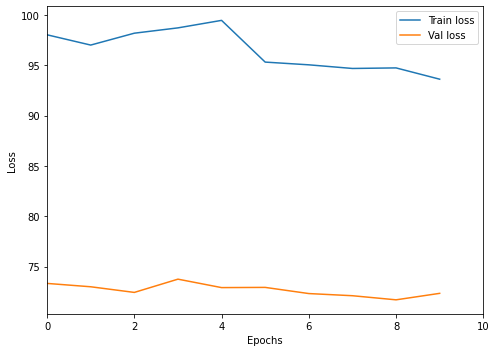

In [42]:
plt.figure(figsize=(7,5))
plt.plot(train_loss3, label='Train loss')
plt.plot(val_loss3, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, num_epochs)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

In [43]:
weights_file = os.path.join(weights_dir, 'mixmodel_scalar2d_1s_{:04d}_{:.4f}.pt'.format(40, 72.3425))
torch.save(model.state_dict(), weights_file)